Import Libraries
TO DO
1) Describe Grid Location bottom left hand location and Cell Size
2) Plot the vector using x y coordinates.
3) Compare to Raster Stat Results, need to make sure that it only includes the cells fully inside (not on the border of the vector.

In [2]:
# TO DO

## 1) Fix edge case where the top row (where y index > 0) causing numpy to wrap to the bottom of Y
## 2) Add speed tests for a larger dataset

In [3]:
import numpy as np
from osgeo import gdal
from scipy import stats
from rasterstats import zonal_stats
from shapely.geometry import Point, Polygon
from osgeo import ogr
from math import ceil,floor
import matplotlib.pyplot as plt

<img src="data/thumb.png" alt="Drawing" style="width: 300px;"/>

Load test data

In [4]:
Grid_Name = "data\\nlcd_2001_landcover_2011_edition_2014_10_sub.tif"

r = gdal.Open(Grid_Name)
shape = "data\\test.shp"
g = np.array(r.GetRasterBand(1).ReadAsArray())


In [5]:
class dtFZS:
    def __init__(self, img):

        r = gdal.Open(Grid_Name)
        self.g = np.array(r.GetRasterBand(1).ReadAsArray())
        
        self.clSze = r.GetGeoTransform()[1]
        self.ulX = r.GetGeoTransform()[0]
        self.ulY = r.GetGeoTransform()[3]
        
        self.brX = (self.g.shape[0] * self.clSze) + self.ulX
        self.brY = self.ulY - (self.g.shape[0] * self.clSze)   
        
        self.geo = r.GetGeoTransform()
        
        def dtFZS(g,out):
            for xw in range(0,g.shape[1]):
                for yw in range(0,g.shape[0]):
                    out[yw,xw] = out[yw-1,xw] + g[yw,xw]

        self.data = np.zeros(g.shape,dtype='uint64')
        
        dtFZS(g,self.data)
        
dFZS = dtFZS(Grid_Name)

Create Helper Functions to move between world and grid cordinates

In [7]:
## Input (world cords; x1, x2, Grid Upper Left, and Cellsize)
## Returns (grid cords; list(x))
## x1 and x2 represent vertexes on a polygon in order

def x_world_to_grid(wx1,wx2,dtFZS):
    
    x1a = min(wx1,wx2)
    x2a = max(wx1,wx2)
    
    xstart = ceil  ((x1a - dtFZS.ulX - (dtFZS.clSze/2)) / dtFZS.clSze)
    xstop =  floor ((x2a - dtFZS.ulX - (dtFZS.clSze/2)) / dtFZS.clSze)

    return(list(range(xstart,xstop+1)))

In [8]:
## Input (grid cords; list(x))
## Returns(world cords centroid ;(list(X)))

def x_grid_to_world(gx,dtFZS):
    return [i * dtFZS.clSze + dtFZS.ulX + (dtFZS.clSze/2) for i in gx]

In [9]:
## Input(world cords centroid ;(list(X)))
## Returns(world cords centroid ;(list(y)))

def y_world_pred(wx1,wx2,wy1,wy2,wxpred):
    slope = 0;
    if (wx1 > wx2):
        wx1,wx2,wy1,wy2 = wx2,wx1,wy2,wy1
    if(wx1 != wx2):    
        slope = (wy2-wy1)/(wx2-wx1)

    return [(slope * (i-wx1)) + wy1 for i in wxpred]

In [10]:
## Input(world cords centroid ;(list(y)))
## Returns (grid cords; list(y))

def y_world_to_grid(wypred,dtFZS):
        return [floor((dtFZS.ulY - i - (dtFZS.clSze/2)) / dtFZS.clSze ) for i in wypred] 

In [51]:
## Input(world Cords for 2 vertexes on a polygon, TL corner of grid, and cellsize)
## Returns(y,x grid cords)

def xy_grid(wx1,wx2,wy1,wy2,dtFZS):
    xgrid  = x_world_to_grid(wx1,wx2,dtFZS)
    wxpred = x_grid_to_world(xgrid,dtFZS)  
    wypred = y_world_pred(wx1,wx2,wy1,wy2,wxpred)
    ygrid  = y_world_to_grid(wypred,dtFZS)
    cords = ((ygrid,xgrid))
    cords = [cord for cord in cords if cord[0]>=0]
    return((ygrid,xgrid))

In [54]:
## Input(list of cords in world, summed down grid, real-world grid tl, cllSze)
## Output Sum v in polygon

def FstZS(v,DS_FstZS):
    total = 0;    
    for p in range(1,(len(v)+0)):
        if v[p][0] > v[p-1][0]:
            cords = xy_grid(v[p][0],v[p-1][0],v[p][1],v[p-1][1],DS_FstZS)
            total += np.sum(DS_FstZS.data[cords])
        elif v[p][0] < v[p-1][0]: 
            cords = xy_grid(v[p][0],v[p-1][0],v[p][1],v[p-1][1],DS_FstZS)
            total -= np.sum(DS_FstZS.data[cords])
    return int(total)

In [55]:
def test(v):
    
    FstZSout = FstZS(v,dFZS)
    Rastsout = zonal_stats(Polygon(v) ,Grid_Name,stats= "sum")
    
    return (float(FstZSout) , float(Rastsout[0]['sum']) )

In [56]:
def create_polys():
    ## add in Random Generator
    ## Replace input with grid

    gmx = dFZS.ulX+((dFZS.brX-dFZS.ulX)/2)
    gmy = dFZS.brY+((dFZS.ulY-dFZS.brY)/2)
    
    tlx =  np.random.randint(dFZS.ulX,gmx,1)
    tly =  np.random.randint(gmy,dFZS.ulY,1)
    brx =  np.random.randint(gmx,dFZS.brX,1)
    bry =  np.random.randint(dFZS.brY,gmy,1)

    v = [(tlx,tly),(tlx,bry),(brx,bry),(brx,tly),(tlx,tly)]
    return v

In [57]:
tst = []
m = 10

for i in range(1,m):
    ##test = np.zeros(2,m)
    v   =  create_polys()
    tst.append(test(v))

C:\Users\smh362\AppData\Local\Continuum\Anaconda3\lib\site-packages\rasterstats\main.py:145: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
C:\Users\smh362\AppData\Local\Continuum\Anaconda3\lib\site-packages\rasterstats\io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)


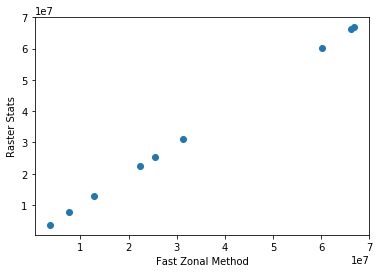

In [58]:
#print(tst)
plt.scatter(y=[t[1] for t in tst],x= [t[0] for t in tst])
plt.xlabel("Fast Zonal Method")
plt.ylabel("Raster Stats")              
plt.show()   